In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime


import jenkspy

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### Binarization Step Parameters ###
bin_method = "GMM" # "GMM", "Jenks", "kmeans"
snr_pval = 0.01
min_n_samples = -1 # define authomatically if -1

### Feature clustering parameters ###
min_SNR = 0.5
clust_method = "DESMOND"

if clust_method == "WGCNA":
    p1 = 10 # power for correlation matrix [1-30]
    p2 = 10 # power for tree cutof height 
    
if clust_method == "DESMOND":
    # PGM parameters
    alpha = 10.0 
    beta_K = 1.0

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10

# seed - makes sense only for GMM and DESMOND - TBA
seed = 42


### input and output  ###

verbose = True
plot_all = True

# whether to load and to save binarized data
load = True
save = True

out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-BRCA"#

data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv"
#exprs_file = data_dir + "METABRIC_1904_14K.nolog2_exprs_z.tsv"
#exprs_file = data_dir + "METABRIC_299TNBC_14K.nolog2_exprs_z.tsv"
#exprs_file = "/home/olya/TUM/DESMOND/DESMOND2/OV_cancer/OV_norm_counts.log2.z.tsv"

In [3]:
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Will save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of samples
if min_n_samples == -1:
    min_n_samples = int(max(20,0.01*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Will save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA*
Mininal number of samples in a module: 20


# 0) Find the trend between SNR and bicluster size

1) for all sizes [min_n_samples, int(N/2)+ min_n_samples], generate splits of random samples drawn from normal distributions

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.05; get_snr_thr is a function of bicluser size 


# 1) Binarize individual features

 * Jenks or GMM binariation
 * filtering by sample nubmer and SNR
     - n_samples =< min_n_samples, and
     - SNR > SNR_thr(n_samples)

In [4]:
from method import binarize

show_fits = [ "FOXA1","ESR1","ERBB2",'APOBEC3A',"PIK3R2"] # some exmaple genes 
binarized_expressions = binarize(exprs, method=bin_method, 
                                       load=load, save = save, prefix = out_dir+"/"+basename,
                                       min_n_samples = min_n_samples, snr_pval = snr_pval,
                                       plot_all = plot_all,plot_SNR_thr= 10.0,show_fits =show_fits,
                                       verbose= verbose,seed=seed)

    

Load binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.pv=0.01,method=GMM,direction=UP.bin_exprs.tsv
Load binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.pv=0.01,method=GMM,direction=DOWN.bin_exprs.tsv


# Step 2. Group features into modules
 
 * feature clustering: choose WGCNA or DESMOND 
 - features with the same 1/0 profiles are grouped to modules
 - runs for up- and down-regulated features separately
 
  

##    WGCNA:

In [5]:
if clust_method == "WGCNA":
    from method3 import run_WGCNA
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        suffix  = ".pv="+str(snr_pval)+",method="+bin_method+",direction="+d
        fname = out_dir+"/"+basename+ suffix +".bin_exprs.tsv"
        clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)

## DESMOND:

time:	Initial state created in 5.2 s.
		LP memory, 12.04 M
		step  1 16.9 s
		step  2 7.5 s
		step  3 5.9 s
		step  4 4.8 s
		step  5 3.9 s
		step  6 3.7 s
		step  7 2.9 s
		step  8 3.1 s
		step  9 3.1 s
		step  10 2.7 s
		step  11 2.7 s
			features oscilating in the last 10 steps: 355
		step  12 2.7 s
			features oscilating in the last 10 steps: 174
		step  13 3.0 s
			features oscilating in the last 10 steps: 96
		step  14 2.8 s
			features oscilating in the last 10 steps: 65
		step  15 3.0 s
			features oscilating in the last 10 steps: 47
		step  16 2.6 s
			features oscilating in the last 10 steps: 42
		step  17 2.7 s
			features oscilating in the last 10 steps: 42
		step  18 2.9 s
			features oscilating in the last 10 steps: 41
		step  19 2.6 s
			features oscilating in the last 10 steps: 40
		step  20 2.6 s
			features oscilating in the last 10 steps: 42
			convergence condition: False ; curve slope: -0.21
		step  21 3.0 s
			features oscilating in the last 10 steps: 39
			conver

Genes assigned to more than 1 module: 1


time:	Initial state created in 3.0 s.
		LP memory, 10.20 M
		step  1 12.9 s
		step  2 7.9 s
		step  3 4.7 s
		step  4 4.3 s
		step  5 4.1 s
		step  6 3.5 s
		step  7 3.8 s
		step  8 3.3 s
		step  9 2.9 s
		step  10 2.5 s
		step  11 2.7 s
			features oscilating in the last 10 steps: 481
		step  12 2.3 s
			features oscilating in the last 10 steps: 282
		step  13 2.3 s
			features oscilating in the last 10 steps: 218
		step  14 2.3 s
			features oscilating in the last 10 steps: 178
		step  15 2.2 s
			features oscilating in the last 10 steps: 134
		step  16 2.3 s
			features oscilating in the last 10 steps: 109
		step  17 2.3 s
			features oscilating in the last 10 steps: 84
		step  18 2.3 s
			features oscilating in the last 10 steps: 66
		step  19 2.4 s
			features oscilating in the last 10 steps: 52
		step  20 2.3 s
			features oscilating in the last 10 steps: 45
			convergence condition: False ; curve slope: -0.37
		step  21 2.4 s
			features oscilating in the last 10 steps: 37
			co

Genes assigned to more than 1 module: 0


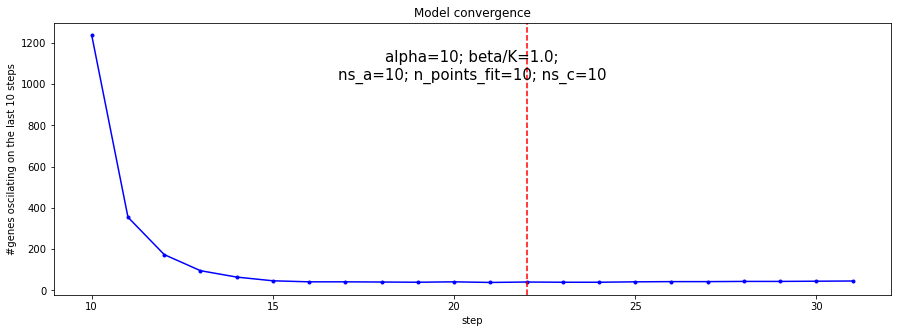

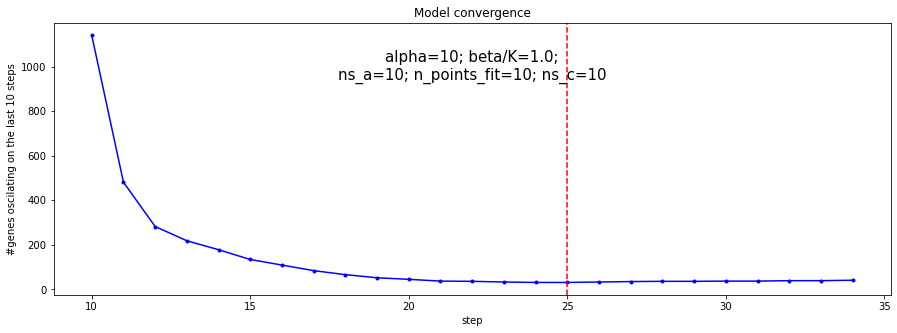

In [6]:
if clust_method == "DESMOND":
    from pgm import run_sampling
    # PGM parameters
    alpha = 10 # convergence fails from 0.25; 0.33 is still Ok
    beta_K = 1.0

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10
    from method2 import set_initial_conditions, sampling, get_consensus_modules

    clustering_results ={}
    for d in ["UP","DOWN"]:
        exprs_bin = binarized_expressions[d]
        genes = exprs_bin.columns.values
        clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.5,
                    max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                    n_points_fit = n_points_fit, tol = 0.1,
                    n_steps_for_convergence = n_steps_for_convergence,
                    verbose =verbose,plot_all=plot_all)

# 3. Split each module to bicluster and background

 * Jenks is th only option, GMM makes no sense for small biclusters of 2-3-5 genes 
 * based on 1/0 profile
 * if min_SNR is set, remove genes not matching with the rest of bicluster

In [8]:
from method import modules2biclsuters_jenks

biclusters, not_clustered = modules2biclsuters_jenks(clustering_results,exprs,binarized_expressions,
                                                     min_SNR = min_SNR,min_n_samples=min_n_samples,
                                                     snr_pval=snr_pval,
                                                     bin_method = bin_method, clust_method = clust_method,
                                                     result_file_name = out_dir+basename,
                                                     directions=["UP","DOWN"],
                                                     plot=False,verbose = False)

UP : 718 features clustered into 66 modules, 562 - not clustered.
DOWN : 690 features clustered into 50 modules, 481 - not clustered.
